In [ ]:
pip install --no-cache-dir -r requirements.txt

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import getpass
import warnings
import pathlib
import os 
from tqdm import tqdm

from ExtracaoDados import ExtracaoDados
from PreProcessamento import PreProcessamento
from ModelosRepresentacao import ModelosEstatisticos, SentenceEmbeddings, WordEmbeddings
from ExtracaoConhecimento import Agrupamento, CompreensaoSemantica, CompreensaoEmocional

warnings.filterwarnings('ignore')
tqdm.pandas()

## <center>Processamento de Linguagem Natural em Textos de Mídias Sociais: Fundamentos, Ferramentas e Aplicações</center>

### <center>XXVIII Simpósio Brasileiro de Sistemas Multimídia e Web (WebMedia 2022)</center>

<br></br>

<center>Frances A. Santos (UNICAMP), Jordan Kobellarz (UTFPR), Fábio R. de Souza (USP), Leandro A. Villas (UNICAMP), Thiago H. Silva (UTFPR)</center>

<br></br>

<center>Curitiba, PR</center>
<center>07 de Novembro de 2022</center>

<a href="https://colab.research.google.com/github/webmedia2022-nlp/course-code/blob/main/NLP_WebMedia2022.ipynb" target="_parent"><img style="float: right;" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir no Colab"/></a>

## Agenda

1. Introdução 
2. Texto de mídias sociais: suas principais características e como coletá-los
3. Pré-processamento textual
4. Representação de textos utilizando vetores numéricos
5. Modelagem e extração de conhecimento
6. Compreensão semântica e emocional
7. Possíveis aplicações
8. Perguntas & Respostas

# <center>1. Introdução</center>

<img src="figs/social-media.jpeg" style="float: center; zoom:100%;" />

Mídias sociais são acessadas por aproximadamente 4,7 bilhões de usuários em todo o planeta (i.e., 59% da população) [Kemp 2022]

### Exemplo (Twitter):

* 200 Bilhões de postagens por ano
* equivalente a 6 mil postagens por segundo

Fonte: [Twitter Usage Statustics](https://www.internetlivestats.com/twitter-statistics)

### Possibilidades para acessar dados públicos em larga escala

* **Twitter** - API (stream e histórico)
* **Reddit** - API (stream e histórico)
* **Meta (Instagram e Facebook)** - Plataforma CrowdTangle
* **Swarm (Forsquare)** - API
* **Flickr** - API
* **Google Places** - API
* etc.

### Aplicações na academia

* análise de fenômenos sociais
* sensoriamento social
* detecção de notícias falsas
* discurso de ódio
* polarização política
* etc.

### Aplicações na indústria

* benchmarking (comparação com concorrentes)
* forecasting (análise de tendências)
* sistemas de recomendação
* personalização / customização em larga escala
* análise de risco
* etc.

# <center>2. Textos de mídias sociais</center>

### Onde encontrar dados textuais?

* postagens
* artigos
* mensagens / comentários
* metainformações de páginas, imagens, videos, perfis, postagens, mensagens, etc. 
* extração de texto em imagem, áudio e video
* etc.

## 2.1 Twitter

* Mídia social de *Microblogging*
* Mensagens limitadas a 280 caracteres
* Uma das primeiras redes a disponibilizar uma API para extração de dados públicos em larga escala
* Possibilidade de coleta de dados históricos ou em tempo real (*streaming*)
* Qualquer dado público pode ser acessado, exceto os de perfis privados (menos de 10%)

### Característica proeminente

Simplicidade nas interações e dicionário de dados:

* tweets
* hashtags #
* menções @
* retweets RT
* respostas

### Dados que podem ser obtidos via API

* **texto do tweet**
* **timestamp**
* **autor**
    * nome
    * localização
    * se é verificado
    * quantidade de seguidores, amigos, postagens
    * data de criação da conta
    * língua do perfil
    * etc.
* **geolocalização do tweet (GeoJson)**
    * adicionada explícitamente
    * ou capturada do dispositivo que gerou o tweet
* **entidades**
    * hashtags
    * links
    * menções
    * mídias
* **sinais sociais**
    * quantidade de retweets
    * quantidade de curtidas
    * quantidade de respostas
* etc. 

Conheça o [dicionário completo de dados de um tweet aqui](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet). 

### Exemplo de um tweet

Alguns campos foram omitidos para facilitar a visualização. 

```json
{
  "created_at": "Thu Apr 06 15:24:15 +0000 2017",
  "id_str": "850006245121695744",
  "text": "1\/ Today we\u2019re sharing our vision for the future of the Twitter API platform!\nhttps:\/\/t.co\/XweGngmxlP",
  "user": {
    "id": 2244994945,
    "name": "Twitter Dev",
    "screen_name": "TwitterDev",
    "location": "Internet",
    "url": "https:\/\/dev.twitter.com\/",
    "description": "Your official source for Twitter Platform news, updates & events. Need technical help? Visit https:\/\/twittercommunity.com\/ \u2328\ufe0f #TapIntoTwitter"
  },
  "place": {   
  },
  "entities": {
    "hashtags": [      
    ],
    "urls": [
    ],
    "user_mentions": [     
    ]
  }
}
```

### Limitações e desafios

* Limite de 280 caracteres
    * restringe capacidade argumentativa
    * usuários contornam com uso de contrações de palavras, gírias da internet e emojis
* Representatividade da população
    * pode não representar bem o usuário médio de internet
    * [tendem a ser usadas por pessoas mais jovens, com maior renda e grau de escolaridade](https://blogs.oii.ox.ac.uk/policy/did-you-consider-twitters-lack-of-representativeness-before-doing-that-predictive-study/)
* Representatividade do retorno da API
    * a API de streaming se baseia na [**relevância** e não **completude** dos dados](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/overview)
* Alta incidência de contas robô

In [14]:
pip install --no-cache-dir -r requirements.txt

[autoreload of ModelosRepresentacao.sentenceEmbeddings failed: Traceback (most recent call last):
  File "/home/frances.santos/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/frances.santos/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/frances.santos/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/frances.santos/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/frances.santos/Área de Trabalho/minicurso/course-code/ModelosRepresentacao/sentenceEmbeddings.py", line 1

     |████████████████████████████████| 8.6 MB 4.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import getpass
import warnings
import pathlib
import os 
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path

# Criação do diretório "data/"
Path("data").mkdir(parents=True, exist_ok=True)

from ExtracaoDados import ExtracaoDados
from PreProcessamento import PreProcessamento
from ModelosRepresentacao import ModelosEstatisticos, SentenceEmbeddings, WordEmbeddings
from ExtracaoConhecimento import Agrupamento, CompreensaoSemantica, CompreensaoEmocional

warnings.filterwarnings('ignore')
tqdm.pandas()



/home/frances.santos/anaconda3/lib/python3.7/site-packages/huggingface_hub/snapshot_download.py:11: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  FutureWarning,


### Coletando Tweets

- Utilizaremos a Twitter API v2 para coletar os tweets 
- Acesse a [página de desenvolverdores](https://developer.twitter.com/) e obtenha suas credenciais de acesso
- Limitamos cada coleta a 10 tweets, mas todo o conteúdo dos tweets é adicionado (*appending*) ao arquivo local data/tweets.json
- Além dos campos *id* e *text* que estão presentes nos tweets por padrão, também solicitamos os campos *created_at, entities, geo, lang, public_metrics, source*. Para ver a lista completa de campos possíveis, acesse esta [página](https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet)
- Filtramos para selecionar apenas os tweets escritos em Inglês ( *lang = "en"* ) e que contenham o termo "nyc", que referencia a cidade de Nova Iorque
- Após coletar os tweets, extraímos os valores dos campos *text, timestamp_ms, ...* e retornamos no formato Pandas DataFrame. 

In [ ]:
## Get Twitter API credentials

print("Informe seu 'API KEY'")
twitter_consumer_key = getpass.getpass()

print("Informe seu 'API KEY SECRET'")
twitter_consumer_secret = getpass.getpass()

print("Informe seu 'ACCESS TOKEN KEY'")
twitter_access_token_key = getpass.getpass()

print("Informe seu 'ACCESS TOKEN SECRET'")
twitter_access_token_secret = getpass.getpass()

print("Informe seu 'Bearer TOKEN'")
twitter_bearer_token = getpass.getpass()

In [ ]:
# collect tweets
df_tweets = ExtracaoDados().twitter(
    twitter_consumer_key, 
    twitter_consumer_secret, 
    twitter_access_token_key, 
    twitter_access_token_secret, 
    twitter_bearer_token
)

df_tweets.head()

Conectado
Salvando 10 novos tweets no disco ...


Stream connection closed by Twitter


,id,created_at,geo,retweet_count,reply_count,like_count,quote_count,source,text,length
0,1580182556569645056,2022-10-12T13:04:14.000Z,{},0,0,0,0,Twitter for iPhone,@publicjeremyno1 @NYCMayor Democrat a-holes to...,291
1,1580182563108581377,2022-10-12T13:04:16.000Z,{},17,0,0,0,Twitter for iPhone,RT @MariaBartiromo: NYC mayor ‘unwittingly bec...,140
2,1580182558830391297,2022-10-12T13:04:15.000Z,{},0,0,0,0,Twitter for Android,"@Nofrills86 @MSNBC Seriously, you're disturbed...",189
3,1580182578438426624,2022-10-12T13:04:19.000Z,{},0,0,0,0,Twitter Web App,"Support if you can, $ go to students in Wayne,...",75
4,1580182577201045506,2022-10-12T13:04:19.000Z,{},0,0,0,0,Twitter Web App,@wizkhalifa Who is lonely like me?,37


## 2.2 Reddit

* mídia social baseada em fóruns de discussão
* comunidades/fóruns → \subreddits
* mais de 100K comunidades e 50 mi de usuários ativos diariamente em [2020](https://www.redditinc.com/advertising/audience)

### Características proeminentes

* sistema de moderação autoorganizável
    * \subreddits possuem regras próprias criadas pelos moderadores e membros
    * algumas comunidades possuem alto nível de comprometimento com as regras propostas
    * mecanismos de recompensa para colaboradores ativos
* possibilidade de coletar dados em stream e histórico
    * vantagem de permitir a recuperação do histórico completo
* permite acesso à qualquer informação disponível publicamente
    * inclui postagens, comentários, perfis, comunidades e suas respectivas metainformações

### Dados que podem ser obtidos via API

**[submission (postagem)](https://praw.readthedocs.io/en/stable/code_overview/models/comment.html)**
* id
* url
* permalink
* created_utc
* title
* selftext (conteúdo da postagem)
* score (número de upvotes)
* [author](https://praw.readthedocs.io/en/stable/code_overview/models/comment.html) (Redditor)
    * name
    * created_utc
    * comment_karma (pontuação do usuário)
    * has_verified_email
    * etc.
* [comments](https://praw.readthedocs.io/en/stable/code_overview/models/comment.html) (árvore de comentários -- necessário percorrer com método específico para isso)
    * author (Redditor)
    * body
    * distinguished
    * etc.
* distinguished (se a postagem foi destacada pelo moderador)
* edited (se a postagem foi editada)
* is_original_content (se foi marcada automaticamente como conteúdo original)
* over_18 (se é conteúdo para maiores de 18 anos)
* etc.

### Limitações e desafios

* a plataforma permite um alto grau de anonimidade
    * é encorajado o uso de pseudônimo
    * é possível fazer cadastro sem verificação
    * abertura para comportamentos anti-éticos em comunidades não moderadas / permissivas
* cada comunidade possui regras próprias
    * práticas de moderação distintas
    * dificultando a comparação 
* liberdade no formato
    * campo aberto com possibiidade de uso de html e markdown
* alta incidência de bots
    * criam, fazem a curadoria e moderam conteúdos 

### Coletando Posts de \subreddits

- Utilizaremos a [API do Reddit](https://www.reddit.com/dev/api) para coletar posts
- Você deverá criar uma conta para acessar a API em [reddit.com](https://reddit.com)
- Depois de criar a conta, obtenha os Client ID e o Client Secret
- No exemplo a seguir, coletamos os top 100 posts de 5 subreddits, contendo o texto, url, número de comentários, data de criação e score (número de upvotes do post)
- Os dados são salvos no arquivo local data/reddit_posts.csv

In [ ]:
## Get Reddit API credentials

print("Informe seu 'CLIENT ID'")
REDDIT_CLIENT_ID = getpass.getpass()

print("Informe seu 'CLIENT SECRET'")
REDDIT_CLIENT_SECRET = getpass.getpass()

In [ ]:
# Subreddits with serious/relevant discussions
subreddits = [
    'politics',
    'AskHistorians',
    'changemyview',
    'COVID19',
    'EverythingScience',
    'science'
]

# collect top 100 posts from each subreddit
df_reddit_posts = ExtracaoDados().reddit(
    REDDIT_CLIENT_ID, 
    REDDIT_CLIENT_SECRET,
    subreddits=subreddits,
    top_n=100
)

In [ ]:
# show some posts with text
df_reddit_posts[df_reddit_posts['length'] > 0].tail(5)

## 2.3 Facebook (Meta)

### Características proeminentes

* alto grau de controle de privacidade
* o anonimato é desencorajado 

### Formas de obter dados

* via API nativa (limitada)
* via web scraping (desencorajado)
* via polls com usuários (não escalável)
* via programa [Social Science One](https://socialscience.one/grant-process) (acesso direto à base do Facebook | difícil acesso | apenas para uso acadêmico)
* via plataforma do [CrowdTangle](https://crowdtangle.com) (dados limitados a páginas e grupos famosos)

### [CrowdTangle](https://crowdtangle.com)

* iniciativa da Meta criada para jornalistas, agências de checagem de fatos, profissionais de marketing e pesquisadores
* possibilidade de consultar e visualizar dados em tempo real pela interface (dashboards)
* mesmos dados apresentados na interface podem ser obtidos via API

* informações que **podem** ser coletadas:
     * quando algo foi postado
     * tipo do post (video, imagem, texto)
     * página, conta ou grupo onde o conteúdo foi postado
     * quantidade de interações (likes, reações, comentários, compartilhamentos, visualizações de videos)
     * páginas públicas ou contas que compartilharam o conteúdo

* informações que **não podem** ser coletadas:
    * alcance ou impressões de um post
    * conteúdos efêmeros, como stories, por exemplo
    * informações demográficas de usuários

* a base de dados disponível se limita a:
    * contas famosas (aprox. ~7 mi de páginas, grupos ou perfis verificados em 08/06/2021), incluindo:
        * páginas públicas com mais de 50K curtidas
        * grupos públicos com mais de 95K membros
        * grupos públicos dos Estados Unidos com mais de 2K membros
        * todos os perfis verificados

### Exemplo de retorno da API do CrowdTangle

```json
{
    "status": 200,
    "result": {
        "posts": [
            {
                "platformId": "47657117525_10154014482272526",
                "platform": "Facebook",
                "date": "2016-02-12 23:38:14",
                "updated": "2020-08-23 05:48:22",
                "type": "live_video_complete",
                "message": "Draymond at Foot Locker for #NBAAllStarTO with a special shoutout to #DubNation.",
                "expandedLinks": [
                    {
                        "original": "https://www.facebook.com/warriors/videos/10154014482272526/",
                        "expanded": "https://www.facebook.com/warriors/videos/10154014482272526/"
                    }
                ],
                "link": "https://www.facebook.com/warriors/videos/10154014482272526/",
                "postUrl": "https://www.facebook.com/warriors/posts/10154014482272526",
                "subscriberCount": 6041837,
                "score": 4.750579867017164,
                "media": [
                    {
                        "type": "video",
                        "url": "https://video-sea1-1.xx.fbcdn.net/v/t42.1790-29/12718926_1213464465334694_1083747983_n.mp4?_nc_cat=109&_nc_sid=985c63&efg=eyJybHIiOjQ0MiwicmxhIjoxNDIwLCJ2ZW5jb2RlX3RhZyI6InYyXzQwMF9jcmZfMjdfbWFpbl8zLjBfc2QifQ%3D%3D&_nc_ohc=e7Ygz2qv-24AX-wSWX2&rl=442&vabr=246&_nc_ht=video-sea1-1.xx&oh=889e0d776d92a84bb57099cad3d28d55&oe=5F43C879",
                        "height": 0,
                        "width": 0
                    },
                    {
                        "type": "photo",
                        "url": "https://scontent-sea1-1.xx.fbcdn.net/v/t15.5256-10/12526285_831341603658336_1493677499_n.jpg?_nc_cat=101&_nc_sid=1055be&_nc_ohc=DH0vfblGwtIAX_x8SBs&_nc_ht=scontent-sea1-1.xx&oh=b09d6378fa261fd45345e79c50c254cb&oe=5F696BE1",
                        "height": 400,
                        "width": 400,
                        "full": "https://scontent-sea1-1.xx.fbcdn.net/v/t15.5256-10/12526285_831341603658336_1493677499_n.jpg?_nc_cat=101&_nc_sid=1055be&_nc_ohc=DH0vfblGwtIAX_x8SBs&_nc_ht=scontent-sea1-1.xx&oh=b09d6378fa261fd45345e79c50c254cb&oe=5F696BE1"
                    }
                ],
                "statistics": {
                    "actual": {
                        "likeCount": 24235,
                        "shareCount": 753,
                        "commentCount": 5675,
                        "loveCount": 33,
                        "wowCount": 18,
                        "hahaCount": 3,
                        "sadCount": 0,
                        "angryCount": 5,
                        "thankfulCount": 0,
                        "careCount": 0
                    },
                    "expected": {
                        "likeCount": 3927,
                        "shareCount": 279,
                        "commentCount": 1041,
                        "loveCount": 1046,
                        "wowCount": 94,
                        "hahaCount": 45,
                        "sadCount": 14,
                        "angryCount": 19,
                        "thankfulCount": 0,
                        "careCount": 2
                    }
                },
                "account": {
                    "id": 19889,
                    "name": "Golden State Warriors",
                    "handle": "warriors",
                    "profileImage": "https://scontent-sea1-1.xx.fbcdn.net/v/t1.0-1/p200x200/74788912_10158146665972526_3545220405897723904_n.jpg?_nc_cat=1&ccb=2&_nc_sid=dbb9e7&_nc_ohc=9snUpG_pdlQAX90IhWM&_nc_ht=scontent-sea1-1.xx&tp=6&oh=f8a3d3b62b507966ecc68de3b557fe84&oe=5FBF1185",
                    "subscriberCount": 11580228,
                    "url": "https://www.facebook.com/47657117525",
                    "platform": "Facebook",
                    "platformId": "47657117525",
                    "accountType": "facebook_page",
                    "pageAdminTopCountry": "US",
                    "verified": true
                },
                "videoLengthMS": 307968,
                "liveVideoStatus": "completed",
                "Id": "19889|10154014482272526",
                "legacyid": 1686762829
            }
        ]
    }
}
```

### Limitações e desafios

* dados limitados a contas famosas
    * contas menos famosas são subrepresentadas
* não é possível saber quem reagiu ou comentou em posts
* ferramenta muito nova / pouco explorada

### Coletando Posts no CrowdTangle

* Utilizaremos a API do CrowdTangle para extrair posts do Facebook -- [documentação](https://github.com/CrowdTangle/API/wiki)
* O primeiro passo é criar uma conta no CrowdTangle, depois criar um dashboard e obter o token da API para acessar os dados do dashboard
* Para coletar posts via API, é necessário criar pelo menos uma lista em seu dashboard recém criado
* Em nosso caso, criaremos uma lista para monitorar posts de páginas de mídias de notícias, incluindo CNN, NYT, BBC, NBC, NPR, Reuters, etc. 
* [Esse video explica como usar a interface do CrowdTangle para criar listas](https://vimeo.com/588999918). 
* [Esse video explica como acessar os dados via API](https://vimeo.com/453763307) explicando como executar todos os procedimentos acima

> Observação: não é possível criar uma lista via API, somente pela interface do dashboard.

In [ ]:
## Get CrowdTangle API credentials

print("Informe seu 'API_TOKEN'")
CROWDTANGLE_API_TOKEN = getpass.getpass()

In [ ]:
# collect top 100 posts in each month from start to end date
df_facebook_posts = ExtracaoDados().facebook(
    CROWDTANGLE_API_TOKEN, 
    search_term='covid-19',
    start_date = '2020-04-01',
    end_date = '2021-04-01'
)

In [ ]:
# show some posts 
df_facebook_posts.tail(3)

## 3. Pré-processamento

A tokenização é um método para...

In [ ]:
pipeline = PreProcessamento(dados)

tokens = pipeline.tokenizacao()


A stemmização é um método para...

In [ ]:
stem =  pipeline.stemmizacao()

### Modelos de Representação

Modelos Estatísticos

In [ ]:
ModelosEstatisticos()

Word Embeddings

In [ ]:
WordEmbeddings()

## Sentence Embeddings

1. <span style="color:red">SkipThought</span>
2. InferSent
3. **Universal Sentence Encoder (USE)**
4. **SentenceBERT (SBERT)**
5. Language-Agnostic SEntence Representations (LASER)
6. Multilingual Universal Sentence Encoder (mUSE)
7. **Language-agnostic BERT Sentence Embedding (LaBSE)**


In [2]:
sentences = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

## SkipThought
TBD

## InferSent
TBD

In [4]:
# InferSent
# Na primeira execução, é feito o download de arquivos de modelos e embeddings
# Certifique-se de ter pelo menos 9GB disponíveis em disco para isso.
# Devido ao download, a primeira execução é lenta
infersent_embeddings = SentenceEmbeddings().infersent(sentences)
infersent_embeddings.shape

[nltk_data] Downloading package punkt to
[nltk_data]     /home/frances.santos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Found 12(/12) words with w2v vectors
Vocab size : 12


(2, 4096)

## USE
TBD

In [6]:
# USE
# Na primeira execução, é feito o download de arquivos de modelos e embeddings
# Certifique-se de ter pelo menos 1GB disponível em disco para isso.
# Devido ao download, a primeira execução é lenta
use_embeddings = SentenceEmbeddings().use(sentences)
use_embeddings.shape

(11, 512)

## SBERT
TBD

## SBERT

- Utilizaremos o modelo **all-MiniLM-L6-v2**, que é 5x mais rápido que sua versão base (**all-mpnet-base-v2**) e significativamente menor (de 420MB para 80MB), mas ainda mantém um bom desempenho
- O termo **all-** indica que o modelo foi treinado com todos os dados disponíveis (mais de 1 bilhão de pares de treinamento) e são projetados como modelos de propósito geral
- Para mais detalhes, acesse a página do [SBERT](https://www.sbert.net/docs/pretrained_models.html#)

In [8]:
# SBERT
sbert_embeddings = SentenceEmbeddings().sbert(sentences)
sbert_embeddings.shape

(2, 384)

## LASER
TBD

In [5]:
# LASER
# Antes de utilizar o LASER, você deve fazer o download do modelo.
# Para isso, descomente a linha abaixo.
#!python -m laserembeddings download-models "data"
# Você pode informar o código de idioma (ISO 639-1), para cada sentença da lista.
# Por padrão, consideramos que todas as sentenças estão escritas em inglês ("en").
laser_embeddings = SentenceEmbeddings().laser(sentences)
laser_embeddings.shape

(11, 1024)

## mUSE
TBD

In [4]:
# mUSE
# Na primeira execução, é feito o download de arquivos de modelos e embeddings
# Certifique-se de ter pelo menos 300MB disponível em disco para isso.
# Devido ao download, a primeira execução é lenta
muse_embeddings = SentenceEmbeddings().muse(sentences)
muse_embeddings.shape

(11, 512)

## LaBSE
TBD

In [3]:
# LaBSE
labse_embeddings = SentenceEmbeddings().labse(sentences)
labse_embeddings.shape

(2, 768)

## Similaridade entre sentenças

TBD

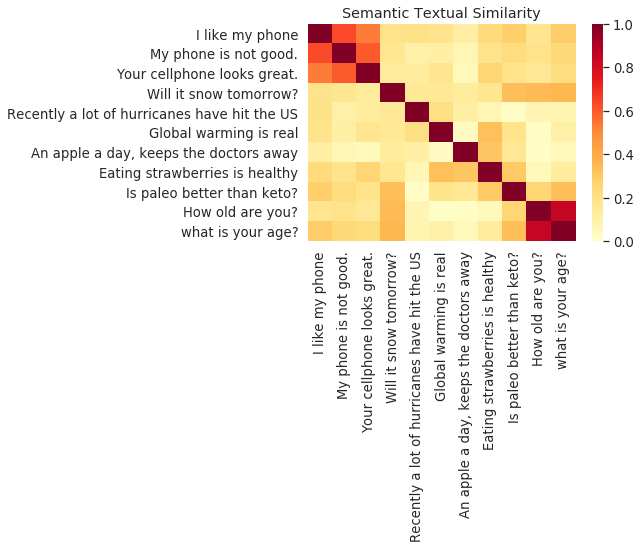

In [11]:
# Exemplo baseado em:
# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


sent_emb = SentenceEmbeddings().labse(sentences) #escolha o modelo de sentence embeddings de sua preferência
plot_similarity(sentences, sent_emb, 90)

### Extração de Conhecimento

### Aplicações